In [1]:
from invisible_cities.cities.components import wf_from_files, WfType
from invisible_cities.cities.components import deconv_pmt, calibrate_pmts, get_pmt_wfs, load_dst
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tables as tb
import os
from scipy.optimize import curve_fit
from matplotlib.cm import get_cmap

In [41]:
kdst = pd.read_hdf("DEMO_Slim.h5","kdst")
display(kdst)

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
529,243585,1.686319e+09,0,0,1,1,200.0,4.604781,23.221897,151525.0,...,109,252.967484,252.967484,1.734042,48.001316,30.617051,56.934437,0.567778,27.785613,25.425956
681,243630,1.686319e+09,0,0,1,1,125.0,1.809542,6.890528,151250.0,...,59,252.256424,252.256424,1.690632,-12.168236,-53.309538,54.680644,-1.795208,19.786410,27.359551
727,243647,1.686319e+09,0,0,1,1,125.0,2.129465,7.849839,333600.0,...,63,309.885590,309.885590,1.968157,38.696795,29.227846,48.494422,0.646887,19.362204,20.822376
761,243657,1.686319e+09,0,0,1,1,150.0,3.807471,13.354649,333300.0,...,80,70.171753,70.171753,1.129120,-22.667181,37.646932,43.944199,2.112758,22.231899,19.698418
772,243661,1.686319e+09,0,0,1,1,125.0,1.938589,6.769459,122275.0,...,86,282.215210,282.215210,1.809884,-10.273464,-15.353004,18.473192,-2.160516,22.533572,25.114597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8181,254404,1.686319e+09,0,0,1,1,150.0,2.003214,8.136253,173575.0,...,80,230.901733,230.901733,1.692743,-17.572494,-12.285485,21.441215,-2.531450,22.947762,21.639030
8182,254405,1.686319e+09,0,0,1,1,150.0,1.804700,7.292423,205325.0,...,55,199.149475,199.149475,1.631500,-32.121694,-29.169228,43.389481,-2.404329,21.378503,19.074921
8239,254428,1.686319e+09,0,0,1,1,150.0,2.044225,8.789826,232550.0,...,71,171.957443,171.957443,1.511900,-12.865438,-32.089526,34.572492,-1.952098,21.628728,22.965030
8260,254439,1.686319e+09,0,0,1,1,125.0,3.491424,12.731092,129425.0,...,75,275.064484,275.064484,1.820509,-8.197052,-12.402134,14.866223,-2.154823,21.024328,20.697632


(0.0, 400.0)

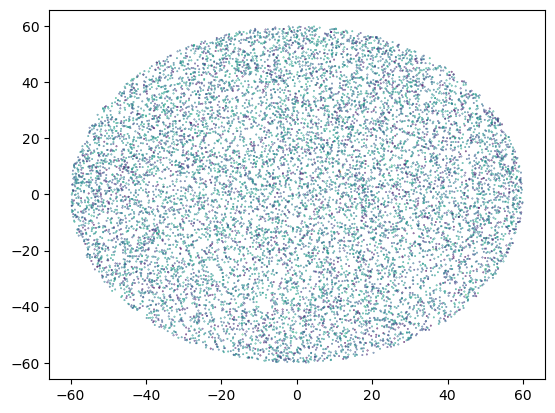

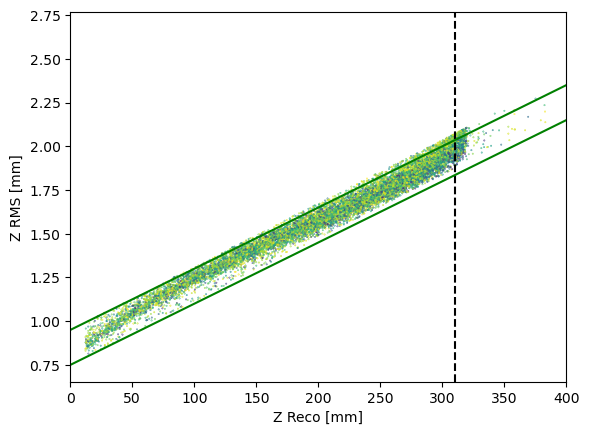

In [66]:
plt.figure()
plt.scatter(kdst.X, kdst.Y, c = kdst.Z,s=0.1);

plt.figure()
plt.scatter(kdst.Z*0.966, kdst.Zrms, c = kdst.R,s=0.1)
plt.xlabel("Z Reco [mm]")
plt.ylabel("Z RMS [mm]")
plt.axvline(x=310, color='black', linestyle='--')

x_line = np.linspace(0,400, 100)
y_line = 0.0035*x_line+0.8
# plt.plot(x_line, y_line, color='red')
y_line = 0.0035*x_line+0.95
plt.plot(x_line, y_line, color='green')
y_line = 0.0035*x_line+0.75
plt.plot(x_line, y_line, color='green')
plt.xlim(0, 400)


In [43]:
wfms = pd.read_hdf("DEMO_Slim.h5","wfm")
display(wfms)


,times,sumwf,z,event
15801,395.025,0.182604,61.455658,38760
15802,395.050,-0.243129,61.455658,38760
15803,395.075,-0.185028,61.455658,38760
15804,395.100,-0.243131,61.455658,38760
15805,395.125,-0.187922,61.455658,38760
...,...,...,...,...
16595,414.875,-0.055524,124.065971,22046
16596,414.900,0.309650,124.065971,22046
16597,414.925,-0.063139,124.065971,22046
16598,414.950,-0.007496,124.065971,22046


In [44]:
# Rebin
tbw = 0.2
tbins =  np.arange(0, 1000+tbw, tbw)
tbins_centre = np.arange(0+tbw/2, 1000+tbw/2, tbw)

zbw = 25
zbins =  np.arange(0, 1000+zbw, zbw)
zbins_centre = np.arange(0+zbw/2, 1000+zbw/2, zbw)

# rw_dfs_merge['times'] = pd.cut(x=rw_dfs_merge['times'], bins=tbins,labels=tbins_centre, include_lowest=True)
wfms['z']     = pd.cut(x=wfms['z'], bins=zbins,labels=zbins_centre, include_lowest=True)

wfms['z'] = wfms['z'].astype(float)

display(wfms)

print(min(wfms.z))
print(max(wfms.z))


,times,sumwf,z,event
15801,395.025,0.182604,62.5,38760
15802,395.050,-0.243129,62.5,38760
15803,395.075,-0.185028,62.5,38760
15804,395.100,-0.243131,62.5,38760
15805,395.125,-0.187922,62.5,38760
...,...,...,...,...
16595,414.875,-0.055524,112.5,22046
16596,414.900,0.309650,112.5,22046
16597,414.925,-0.063139,112.5,22046
16598,414.950,-0.007496,112.5,22046


12.5
537.5


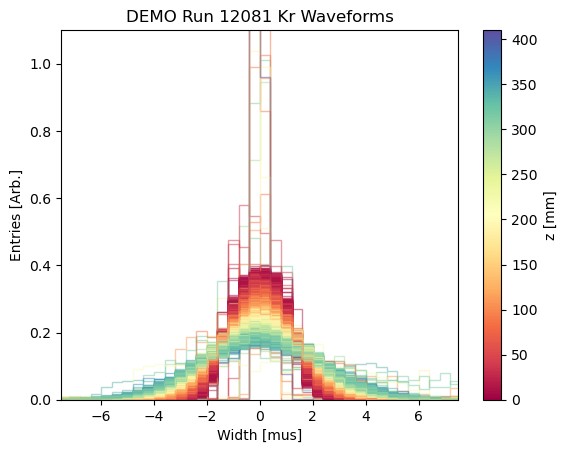

In [49]:
# Fit the distribution 
def Gaussian_(x, A, mu, sigma):
    return A * np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma))

cmap = get_cmap('Spectral')
# cmap = get_cmap('viridis')

counter = 0
plt.figure()

wfms['times'] = wfms['times'].astype(float)
# rw_dfs_merge = rw_dfs_merge[rw_dfs_merge['times'] > 380]

event_ids = wfms.event.unique()

rw_dfs_merge_shifted = []

for e in event_ids: 
    # rebin 
    df = wfms[wfms.event == e]
    df_merged = df.groupby(['times', 'z'], as_index=False)['sumwf'].sum();

    # print(df_merged.z.iloc[0]/410)
    # if (df_merged.z.iloc[0] > 40):
    #     continue

    # Plot the summed waveforms
   
    # plt.plot(df_merged.times, df_merged.sumwf)
    counts, xbins = np.histogram(df_merged.times, weights = df_merged.sumwf, bins = np.linspace(395, 415, 51))

    bin_centers = xbins+ (xbins[1]-xbins[0])/2.0
    bin_centers = bin_centers[:-1]

    popt, pcov = curve_fit(Gaussian_, bin_centers, counts, bounds  = ([0 , 395, 0], [1000, 415, 20]), maxfev=50000)
    # print(popt[1])

    # plt.clf()
    plt.hist(df_merged.times-popt[1], weights = df_merged.sumwf/max(df_merged.sumwf), bins = np.linspace(-10, 10, 51), histtype = "step", color = cmap(df_merged.z.iloc[0]/410), alpha = 0.5, density = True)
    plt.ylim([0, 1.1])
    plt.xlim(-7.5,7.5)

    rw_dfs_merge_shifted.append(pd.DataFrame({"times":bin_centers-popt[1], "sumwf" :  counts, "z": df_merged.z.iloc[0]}))

sm = plt.cm.ScalarMappable(cmap='Spectral', norm=plt.Normalize(vmin=0, vmax=410))

# Add a color bar
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('z [mm]')
plt.xlabel("Width [mus]")
plt.ylabel("Entries [Arb.]")
plt.title("DEMO Run 12081 Kr Waveforms")

rw_dfs_merge_shifted = pd.concat(rw_dfs_merge_shifted)

# plt.show()

# if counter == 40:
#     break

counter+=1

,times,sumwf,z
0,-7.8,-1.323075,62.5
1,-7.4,-1.063645,62.5
2,-7.0,0.178268,62.5
3,-6.6,-0.740273,62.5
4,-6.2,2.779974,62.5
...,...,...,...
45,9.4,-0.990829,112.5
46,9.8,-1.160393,112.5
47,NaN,0.880136,112.5
48,NaN,-0.224593,112.5


[ 62.5 187.5 312.5 237.5 137.5 162.5  37.5  87.5 112.5 262.5 212.5 287.5
 337.5  12.5 362.5 387.5 537.5]


(-7.5, 7.5)

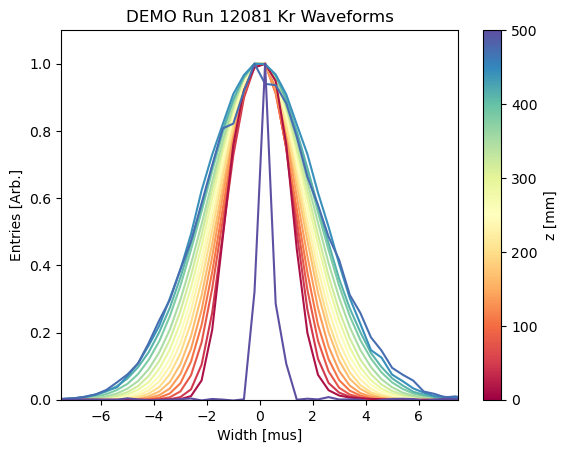

In [58]:
# Try to get the average waveforms
# Rebin
tbw = 0.4
tbins =  np.arange(-10, 10+tbw, tbw)
tbins_centre = np.arange(-10+tbw/2, 10+tbw/2, tbw)
rw_dfs_merge_shifted['times']     = pd.cut(x=rw_dfs_merge_shifted['times'], bins=tbins,labels=tbins_centre, include_lowest=True)
display(rw_dfs_merge_shifted)

zees = rw_dfs_merge_shifted.z.unique()
print(zees)



plt.figure()

for z in zees:
    temp_df = rw_dfs_merge_shifted[rw_dfs_merge_shifted.z == z]
    

    average = temp_df.groupby(['times', "z"], as_index=False)['sumwf'].mean();
    average.sumwf = average.sumwf.fillna(0)
    maxval = temp_df.sumwf.sum()
    # display(average)
    average.sumwf = average.sumwf/max(average.sumwf)
    # display(average)
    # # plt.ylim([0, 0.45])
    # # plt.xlim(-7.5,7.5)

    # # plt.plot(average.times, average.sumwf)
    plt.plot(average.times,  average.sumwf, color = cmap(z/410))

sm = plt.cm.ScalarMappable(cmap='Spectral', norm=plt.Normalize(vmin=0, vmax=500))

# Add a color bar
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('z [mm]')
plt.xlabel("Width [mus]")
plt.ylabel("Entries [Arb.]")
plt.title("DEMO Run 12081 Kr Waveforms")
plt.ylim([0, 1.1])
plt.xlim(-7.5,7.5)

